In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import math
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from torch.distributions import constraints

from physics import compute_penetration_profile
from scipy import constants
from scipy import stats
from configs import respiratorA, temperature, viscosity

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 90

from learning.observation import ObservationModel

Now set the seeds:

In [2]:
seed = 43
np.random.seed(seed)
pyro.set_rng_seed(seed)

# pyro.enable_validation()

Now we define the probabilistic model for the respirator, using deterministic parameters except for the charge density which is given a Gamma prior:
$$
    q \sim \Gamma(\alpha, \beta)
$$
We add multiplicative observation noise for the penetration: $\log P_{obs}(d) = \phi(d) + \epsilon$ where $\epsilon$ is a Gaussian and $\phi(d) = \log P_{model}(d)$.

In [38]:
# prior distribution on q
theta = 3 * constants.nano
beta = 1./theta
alpha = 5
# We use a Gamma prior -- take care in Pyro Gamma is parameterized using (alpha, beta) !
charge_prior = dist.Gamma(alpha, beta)
# charge_prior = dist.Normal(18 * constants.nano, 1 * constants.nano)

observation_model = ObservationModel()

def model(diameters):
    charge = pyro.sample('q', charge_prior)
    resp_model = lambda: respiratorA(charge)
    obs_log = observation_model(diameters, resp_model)
    return obs_log

Text(0.5, 1.0, 'Prior distribution over charges')

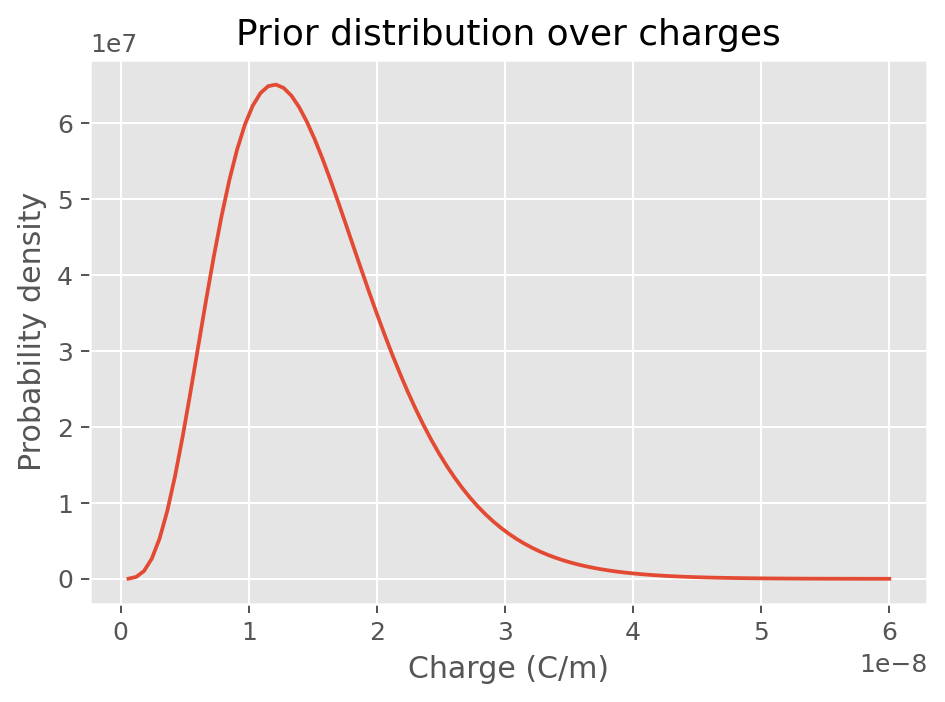

In [39]:
ch_vals_ = torch.linspace(0, 6e-8, 100)[1:]
plt.plot(ch_vals_, charge_prior.log_prob(ch_vals_).detach().exp())
plt.xlabel("Charge (C/m)")
plt.ylabel("Probability density")
plt.title("Prior distribution over charges")

We load the data and plot it, as well as the prior model:

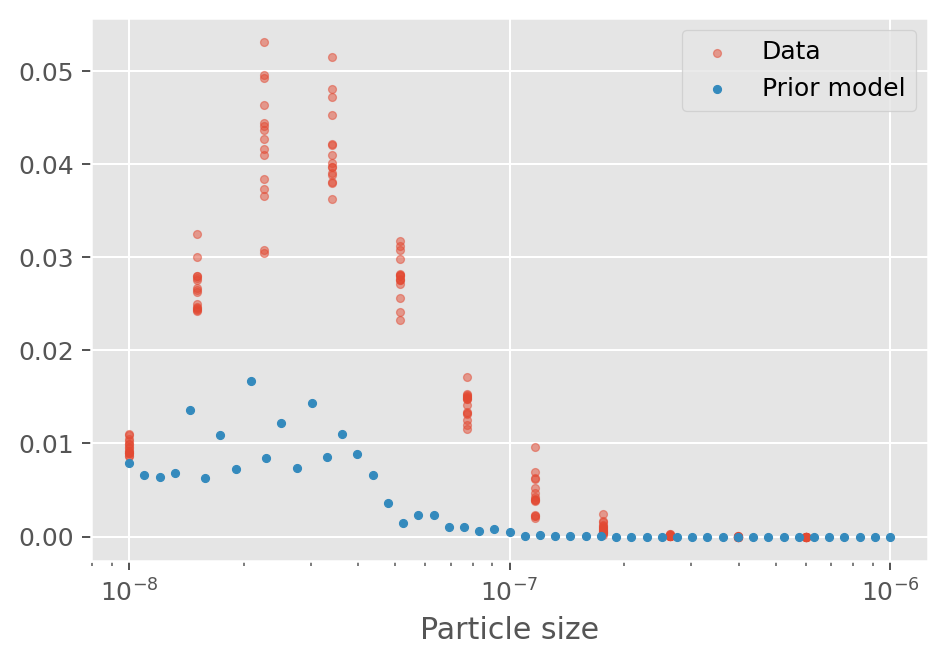

In [43]:
# Inference time diameters
diameters = torch.linspace(math.log(10), math.log(1000), 51)
diameters.exp_()
diameters.mul_(constants.nano);

import pandas as pd
import json

# Load the data
filename = "data/synthetic_respA_batch15.csv"
perf_data = pd.read_csv(filename, index_col=0)
data_diameters = torch.from_numpy(perf_data.index.values)
perf_data = torch.from_numpy(perf_data.values).T

with open("data/synthetic_summary.json") as f:
    metadata = json.load(f)[filename]

plt.scatter(data_diameters.repeat(perf_data.shape[0], 1),
            perf_data, s=10, alpha=.5, label="Data")
plt.scatter(diameters, model(diameters).detach().exp(), s=10, label="Prior model")
plt.xlabel('Particle size')
plt.legend()
plt.xscale('log')

Then, the synethetic data for penetration $\{P(d_m)\}_i$ at multiple particle sizes $d_m$ and samples $i$, are used to condition the model.

In [44]:
# Define a runnable conditioned model
with pyro.plate("data"):
    cond_model = pyro.condition(model, data={'obs_log': perf_data.log()})

## Variational inference

We propose the following variational distribution: the posterior for the charge is
$$
\begin{aligned}
    q \sim \mathrm{ReLU}(\mathcal N(\mu_q, \sigma_q^2))
\end{aligned}
$$

In [47]:
def guide(diameters):
    '''Normal variational posterior.'''
    q_loc = pyro.param('q_loc', torch.tensor(20e-9), constraint=constraints.positive)
    q_std = pyro.param('q_std', torch.tensor(10e-9), constraint=constraints.positive)
    charge_pre = pyro.sample('q_pre', dist.Normal(q_loc, q_std))
    charge = pyro.sample('q', dist.Delta(torch.relu(charge_pre)))
    
    surface_area, layer_params = respiratorA(charge)
    
    debit = 85 * constants.liter / constants.minute
    face_vel = debit / surface_area

    obs_scale = pyro.sample('obs_scale', dist.Delta(torch.tensor(0.1)))
    
    with pyro.plate('diameters'):
        results = compute_penetration_profile(
            diameters, layer_params, face_vel, temperature, viscosity)
    
        obs_log = pyro.sample('obs_log', dist.Normal(results, obs_scale))
        # obs = pyro.deterministic('obs', obs_log.exp())
    return obs_log

In [48]:
optimizer = pyro.optim.Adam({'lr': 0.002}, clip_args={"clip_norm": 10.0})
svi = pyro.infer.SVI(cond_model, guide, optimizer,
                     loss=pyro.infer.Trace_ELBO())

pyro.clear_param_store()
num_iters = 5000
for i in range(num_iters):
    elbo_ = svi.step(data_diameters)
    if (i+1) % 500 == 0:
        print('[Step {:d}] ELBO {:.4g}'.format(i+1, elbo_ / len(perf_data)))

[Step 500] ELBO 995.1
[Step 1000] ELBO 969
[Step 1500] ELBO 549.7
[Step 2000] ELBO 516
[Step 2500] ELBO 522.5
[Step 3000] ELBO 516.5
[Step 3500] ELBO 516.4
[Step 4000] ELBO 515.9
[Step 4500] ELBO 515.9
[Step 5000] ELBO 515.9


In [49]:
for name, value in pyro.get_param_store().items():
    print("{:<10}".format(name), pyro.param(name))

q_loc      tensor(1.4683e-08, grad_fn=<AddBackward0>)
q_std      tensor(2.3034e-11, grad_fn=<AddBackward0>)


In [50]:
num_samples = 1000
predictive_svi = pyro.infer.Predictive(model, guide=guide, num_samples=num_samples)

prediction_dict = predictive_svi(data_diameters)
print("Prediction dictionary keys: {}".format(prediction_dict.keys()))

Prediction dictionary keys: dict_keys(['q', 'obs_scale', 'obs_log'])


In [51]:
pred_svi_q = prediction_dict['q'].detach().flatten()
q_prior_samples = charge_prior.sample((num_samples,))

def plot_prior(fig: plt.Figure, q_prior_samples, q_post_samples):
    gap = q_prior_samples.max() - q_prior_samples.min()
    qrange = torch.linspace(0, q_prior_samples.max()+.2*gap)[1:]
    
    probs = torch.exp(charge_prior.log_prob(qrange))
    
    p, = plt.plot(qrange, probs, label="Prior distribution")
    prior_color = p.get_color()
    
    plt.hist(q_prior_samples, bins=n_bins, rwidth=.8, density=True,
             label="Prior samples", color=prior_color, alpha=.8)

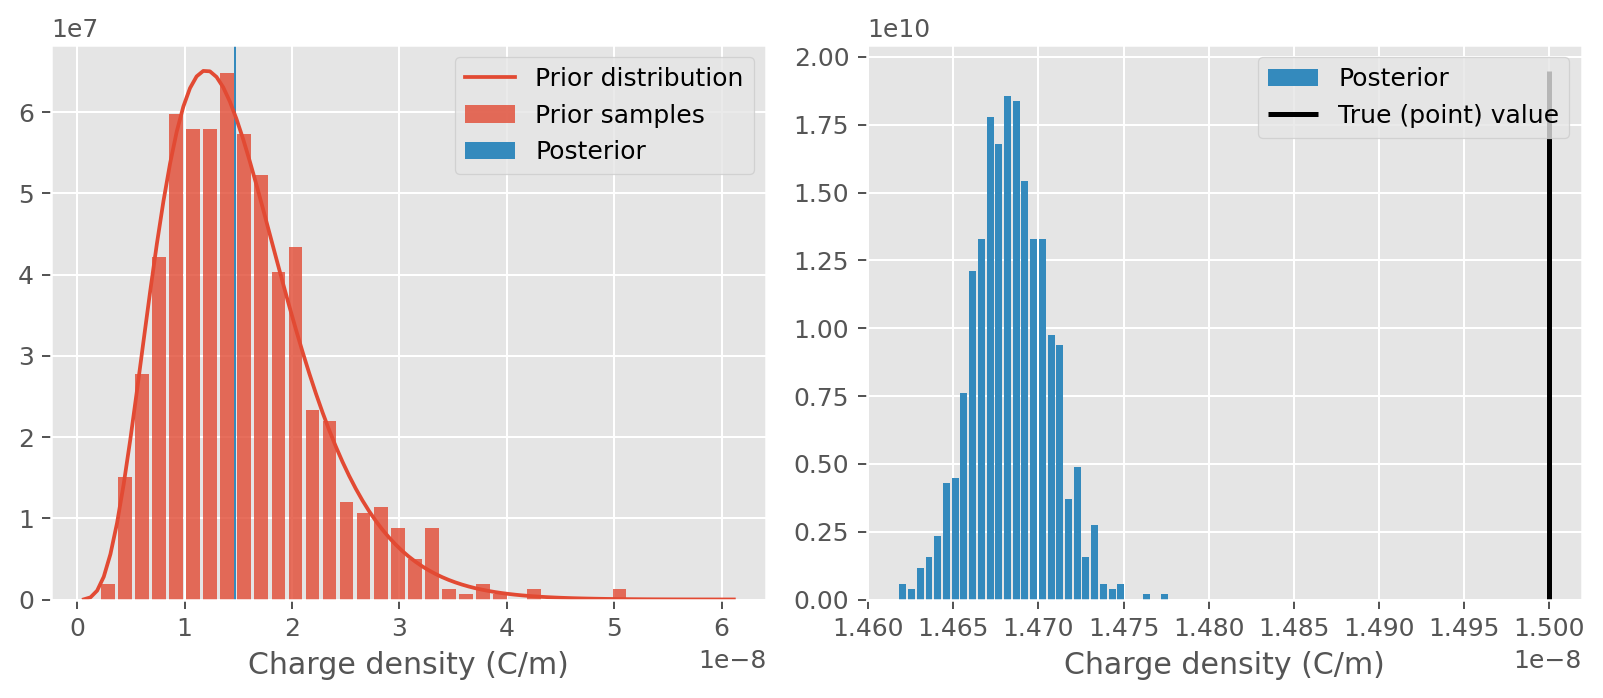

In [52]:
n_bins = int(num_samples ** (1/2))

fig, ax = plt.subplots(1, 2, figsize=(9, 4))

plt.sca(ax[0])
plot_prior(fig, q_prior_samples, pred_svi_q)
ylims = plt.ylim()
plt.hist(pred_svi_q, bins=n_bins, rwidth=.8, density=True,
         label="Posterior")
plt.ylim(*ylims)
plt.legend()
plt.xlabel("Charge density (C/m)")

plt.sca(ax[1])
# plot the posterior distribution histogram of the charge density
plt.hist(pred_svi_q, bins=n_bins, rwidth=.8, density=True,
         label="Posterior", color='C1')
true_charge = metadata.get("true_charge", None)
ylims = plt.ylim()
if true_charge is not None:
    plt.vlines(true_charge, *ylims, ls='-', lw=2, label="True (point) value")

plt.xlabel("Charge density (C/m)")
plt.legend()
plt.tight_layout()

In [53]:
# fig.savefig('assets/inference_example_charge_posterior_SVI.png')

In [54]:
prediction_dict_big = predictive_svi(diameters)

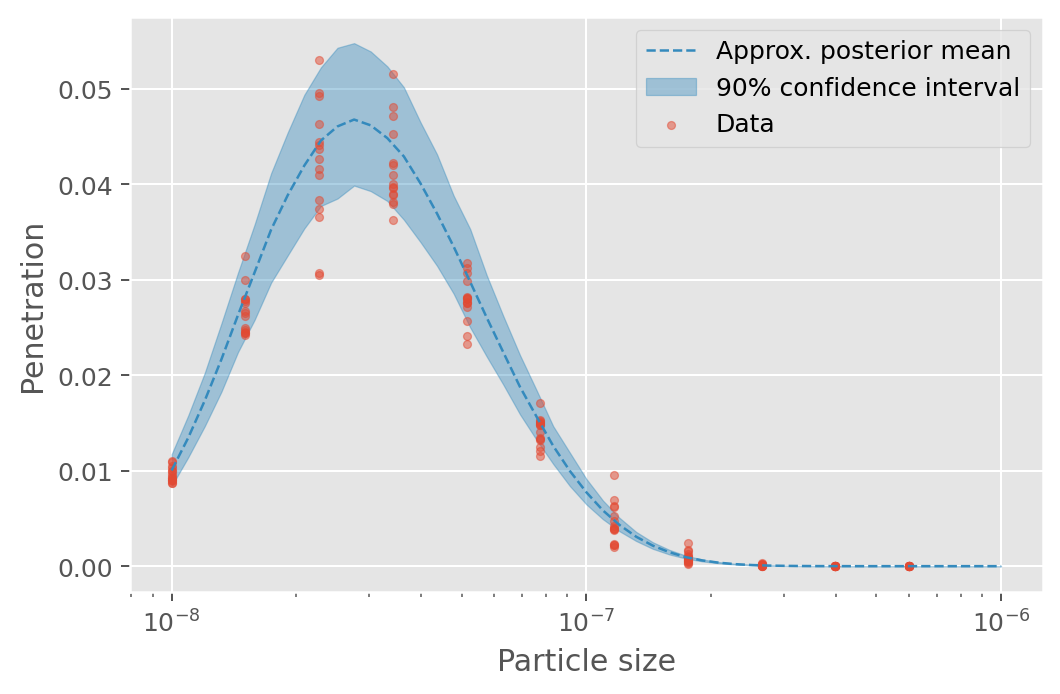

In [55]:
fig = plt.figure()

pred_obs_low, pred_obs_med, pred_obs_high = pyro.ops.stats.quantile(
    prediction_dict_big['obs_log'].detach().exp(), (0.05, 0.5, 0.95))
pred_obs_low = pred_obs_low.detach()
pred_obs_high = pred_obs_high.detach()
pred_obs_med = pred_obs_med.detach()

plt.plot(diameters, torch.mean(prediction_dict_big['obs_log'].detach().exp(), 0),
            label="Approx. posterior mean", color='C1', lw=1., ls='--')
# plt.plot(particle_diam, pred_obs_med, label="Approx. posterior median")
plt.fill_between(diameters, pred_obs_low, pred_obs_high,
                 label="90% confidence interval", color='C1', alpha=.4)
plt.scatter(data_diameters.repeat(len(perf_data), 1), perf_data, alpha=.5, s=10, label="Data")

plt.xscale('log')
plt.xlabel("Particle size")
plt.ylabel("Penetration")
plt.legend()
plt.tight_layout()

In [31]:
# fig.savefig('assets/prediction_SVI.png')